In [1]:
import pandas as pd
import numpy as np

In [2]:
chips_df = pd.read_csv("data/chips.csv")
chips_df["class"] = chips_df["class"].apply(lambda x: +1.0 if x == "P" else -1.0)
chips_df

,x,y,class
0,0.051267,0.699560,1.0
1,-0.092742,0.684940,1.0
2,-0.213710,0.692250,1.0
3,-0.375000,0.502190,1.0
4,-0.513250,0.465640,1.0
...,...,...,...
113,-0.720620,0.538740,-1.0
114,-0.593890,0.494880,-1.0
115,-0.484450,0.999270,-1.0
116,-0.006336,0.999270,-1.0


In [3]:
chips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       118 non-null    float64
 1   y       118 non-null    float64
 2   class   118 non-null    float64
dtypes: float64(3)
memory usage: 2.9 KB


In [4]:
geyser_df = pd.read_csv("data/geyser.csv")
geyser_df["class"] = geyser_df["class"].apply(lambda x: +1.0 if x == "P" else -1.0)
geyser_df["x"] = geyser_df["x"].apply(float)
geyser_df

,x,y,class
0,1.0,4.4,-1.0
1,1.0,3.9,-1.0
2,1.0,4.0,1.0
3,1.0,4.0,-1.0
4,1.0,3.5,-1.0
...,...,...,...
217,23.0,2.1,1.0
218,23.0,4.2,-1.0
219,23.0,2.1,1.0
220,23.0,5.2,-1.0


In [5]:
geyser_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       222 non-null    float64
 1   y       222 non-null    float64
 2   class   222 non-null    float64
dtypes: float64(3)
memory usage: 5.3 KB


In [6]:
from sklearn.preprocessing import StandardScaler

geyser_scaler = StandardScaler()
geyser_scaler.fit(geyser_df.to_numpy()[:, :2])
chips_scaler = StandardScaler()
chips_scaler.fit(chips_df.to_numpy()[:, :2])

# _geyser = StandardScaler().fit_transform(geyser_df.to_numpy())
# _chips = StandardScaler().fit_transform(chips_df.to_numpy())
_geyser = geyser_df.to_numpy()
_chips = chips_df.to_numpy()

rng = np.random.default_rng(0)

rng.shuffle(_geyser)
rng.shuffle(_chips)

X_geyser = geyser_scaler.transform(_geyser[:, :2])
Y_geyser = _geyser[:, 2]
X_chips = chips_scaler.transform(_chips[:, :2])
Y_chips = _chips[:, 2]

# Настройка

In [7]:
import cfml.svm

def accuracy(nn, _np, pn, pp):
    # print(nn, _np, pn, pp)
    return (nn + pp) / (nn + _np + pn + pp)

def accuracy_k_fold(X, Y, kernel, c, batches=5):
    n = X.shape[0]
    nn, _np, pn, pp = 0, 0, 0, 0
    for batch_i in range(batches):
        from_i = batch_i * (n // batches)
        to_i = (batch_i + 1) * (n // batches)
        
        X_test = X[from_i:to_i]
        Y_test = Y[from_i:to_i]
        
        X_train = np.concatenate((X[:from_i], X[to_i:]))
        Y_train = np.concatenate((Y[:from_i], Y[to_i:]))
        
        model = cfml.svm.SimplifiedSMO(X_train, Y_train, c, kernel, seed=0)
        
        for i in range(X_test.shape[0]):
            y_pred = model(X_test[i])
            y_real = Y_test[i]
            # print("=>", y_pred, y_real)
            
            if y_pred == -1.0:
                if y_real == -1.0:
                    nn += 1
                else:
                    pn += 1
            else:
                if y_real == -1.0:
                    _np += 1
                else:
                    pp += 1
                
    return accuracy(nn, _np, pn, pp)

In [8]:
kernel_args = {
    "linear": [()],
    "polynomial": [(2.0,), (3.0,), (4.0,), (5.0,)],
    "gaussian": [(1.0,), (2.0,), (3.0,), (4.0,), (5.0,)]
}

cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

In [9]:
def best_params(X, Y):
    best_acc = 0.0
    best_params = None
    for kernel_name in kernel_args.keys():
        for kernel_arg in kernel_args[kernel_name]:
            for c in cs:
                print(kernel_name, kernel_arg, c)
                acc = accuracy_k_fold(X, Y, cfml.svm.kernel(kernel_name, *kernel_arg), c)
                print(acc)
                if acc > best_acc:
                    best_acc = acc
                    best_params = (kernel_name, kernel_arg, c)
                    print("upd best acc:", best_acc)
    print("best acc:", best_acc)
    print("best params:", best_params)
    return best_params

In [10]:
best_params(X_chips, Y_chips)

linear () 0.05
0.5217391304347826
upd best acc: 0.5217391304347826
linear () 0.1
0.391304347826087
linear () 0.5
0.4434782608695652
linear () 1.0
0.4260869565217391
linear () 5.0
0.4
linear () 10.0
0.3652173913043478
linear () 50.0
0.3826086956521739
linear () 100.0
0.4260869565217391
polynomial (2.0,) 0.05
0.6869565217391305
upd best acc: 0.6869565217391305
polynomial (2.0,) 0.1
0.7565217391304347
upd best acc: 0.7565217391304347
polynomial (2.0,) 0.5
0.7913043478260869
upd best acc: 0.7913043478260869
polynomial (2.0,) 1.0
0.8
upd best acc: 0.8
polynomial (2.0,) 5.0
0.8173913043478261
upd best acc: 0.8173913043478261
polynomial (2.0,) 10.0
0.808695652173913
polynomial (2.0,) 50.0
0.808695652173913
polynomial (2.0,) 100.0
0.8260869565217391
upd best acc: 0.8260869565217391
polynomial (3.0,) 0.05
0.7913043478260869
polynomial (3.0,) 0.1
0.8
polynomial (3.0,) 0.5
0.8
polynomial (3.0,) 1.0
0.782608695652174
polynomial (3.0,) 5.0
0.782608695652174
polynomial (3.0,) 10.0
0.8
polynomial (3.

('polynomial', (2.0,), 100.0)

In [11]:
best_params(X_geyser, Y_geyser)

linear () 0.05
0.9
upd best acc: 0.9
linear () 0.1
0.8863636363636364
linear () 0.5
0.8863636363636364
linear () 1.0
0.9
linear () 5.0
0.9045454545454545
upd best acc: 0.9045454545454545
linear () 10.0
0.9045454545454545
linear () 50.0
0.9
linear () 100.0
0.9090909090909091
upd best acc: 0.9090909090909091
polynomial (2.0,) 0.05
0.9045454545454545
polynomial (2.0,) 0.1
0.8909090909090909
polynomial (2.0,) 0.5
0.9
polynomial (2.0,) 1.0
0.8954545454545455
polynomial (2.0,) 5.0
0.9
polynomial (2.0,) 10.0
0.8954545454545455
polynomial (2.0,) 50.0
0.8954545454545455
polynomial (2.0,) 100.0
0.8909090909090909
polynomial (3.0,) 0.05
0.8954545454545455
polynomial (3.0,) 0.1
0.9
polynomial (3.0,) 0.5
0.8954545454545455
polynomial (3.0,) 1.0
0.8863636363636364
polynomial (3.0,) 5.0
0.8954545454545455
polynomial (3.0,) 10.0
0.8863636363636364
polynomial (3.0,) 50.0
0.8954545454545455
polynomial (3.0,) 100.0
0.8863636363636364
polynomial (4.0,) 0.05
0.8954545454545455
polynomial (4.0,) 0.1
0.87727

('linear', (), 100.0)

In [32]:
import matplotlib.pyplot as plt

def demo(X, Y, scaler, kernel_name, kernel_args, c):
    X_scaled = scaler.transform(X)
    
    kernel = cfml.svm.kernel(kernel_name, *kernel_args)
    model = cfml.svm.SimplifiedSMO(X_scaled, Y, c, kernel, seed=0)
    Y_pred = np.zeros(Y.shape[0])
    for i in range(Y.shape[0]):
        Y_pred[i] = model(X_scaled[i])
    
    x0_min, x1_min = np.amin(X, 0)
    x0_max, x1_max = np.amax(X, 0)
    
    xp, yp = np.meshgrid(np.linspace(x0_min, x0_max, 50), np.linspace(x1_min, x1_max, 50))
    
    points = np.c_[xp.ravel(), yp.ravel()]
    for point in points:
        plt.scatter(point[0], point[1], s=20, color=("red" if model(scaler.transform(np.array([point]))[0]) == +1.0 else "blue"))
    
    for i in range(X.shape[0]):
        plt.scatter(X[i][0], X[i][1], s=40, color=("black" if Y[i] == +1.0 else "white"))
        
    plt.show()
    
    

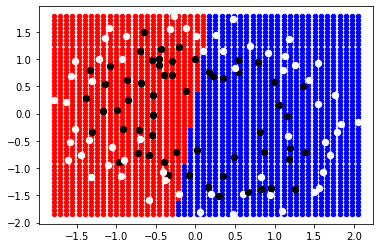

In [33]:
demo(X_chips, Y_chips, chips_scaler, "linear", (), 0.5)

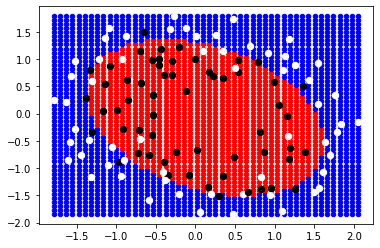

In [34]:
demo(X_chips, Y_chips, chips_scaler, "polynomial", (2.0, ), 100.0)

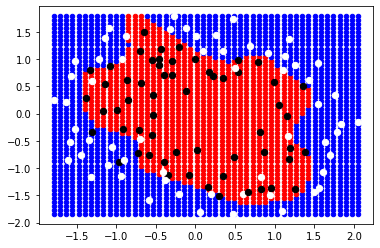

In [35]:
demo(X_chips, Y_chips, chips_scaler, "gaussian", (1.0, ), 10.0)

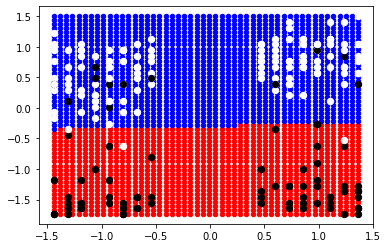

In [36]:
demo(X_geyser, Y_geyser, geyser_scaler, "linear", (), 100.0)

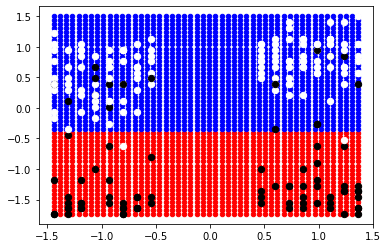

In [37]:
demo(X_geyser, Y_geyser, geyser_scaler, "polynomial", (2.0, ), 0.05)

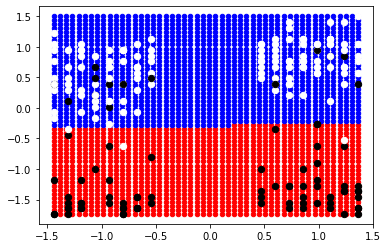

In [38]:
demo(X_geyser, Y_geyser, geyser_scaler, "gaussian", (2.0, ), 0.05)